# 🦠 COVID‑19 EDA & Prediction — Annotated Notebook


This notebook walks through: data loading, exploration, preprocessing, encoding, modeling (KNN via `MultiOutputRegressor`), and simple predictions.

## 📦 Imports & Setup
Load core libraries for data manipulation (`pandas`, `numpy`) and visualization (`matplotlib`, `seaborn`).  
The `%matplotlib inline` magic ensures plots display in the notebook output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 📥 Load the dataset
Read the COVID‑19 dataset from the provided path.  
If you run this in Colab, make sure the path points to your file (e.g., Google Drive).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/covid_19_data.csv') # Load CSV into DataFrame

## 🧹 Quick data audit
`df.info()` summarizes the schema (column types, non‑null counts).  
Use this to spot missing values and understand dtypes before cleaning.

In [5]:
# Inspect schema and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172480 entries, 0 to 172479
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              172480 non-null  int64  
 1   ObservationDate  172480 non-null  object 
 2   Province/State   124594 non-null  object 
 3   Country/Region   172480 non-null  object 
 4   Last Update      172480 non-null  object 
 5   Confirmed        172480 non-null  float64
 6   Deaths           172480 non-null  float64
 7   Recovered        172480 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 10.5+ MB


## 📊 Descriptive statistics
`df.describe()` provides summary stats for numeric columns (count, mean, std, min/max, quartiles).  
Outliers or negative values here might indicate data quality issues.

In [6]:
# Summarize numeric columns
df.describe()

,SNo,Confirmed,Deaths,Recovered
count,172480.000000,1.724800e+05,172480.000000,1.724800e+05
mean,86240.500000,3.323156e+04,1050.030966,2.102825e+04
std,49790.831552,1.031349e+05,3499.436401,1.156598e+05
min,1.000000,-3.028440e+05,-178.000000,-8.544050e+05
25%,43120.750000,4.570000e+02,6.000000,1.000000e+01
50%,86240.500000,4.016500e+03,76.000000,8.580000e+02
75%,129360.250000,1.884300e+04,554.000000,7.229000e+03
max,172480.000000,2.290891e+06,54804.000000,5.624444e+06


In [7]:
df.ObservationDate.head(20)

,ObservationDate
0,01/22/2020
1,01/22/2020
2,01/22/2020
3,01/22/2020
4,01/22/2020
5,01/22/2020
6,01/22/2020
7,01/22/2020
8,01/22/2020
9,01/22/2020


## 🗓️ Convert date column
Convert `ObservationDate` from string to `datetime` so we can extract year/month/day and sort correctly.

In [9]:
df['ObservationDate']= pd.to_datetime(df['ObservationDate']) # Convert string dates to datetime

## 🧹 Quick data audit
`df.info()` summarizes the schema (column types, non‑null counts).  
Use this to spot missing values and understand dtypes before cleaning.

In [10]:
# Inspect schema and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172480 entries, 0 to 172479
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   SNo              172480 non-null  int64         
 1   ObservationDate  172480 non-null  datetime64[ns]
 2   Province/State   124594 non-null  object        
 3   Country/Region   172480 non-null  object        
 4   Last Update      172480 non-null  object        
 5   Confirmed        172480 non-null  float64       
 6   Deaths           172480 non-null  float64       
 7   Recovered        172480 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 10.5+ MB


## 🧪 Work on a copy
Create a working copy `df_tmp` to engineer features (year/month/day) and avoid altering the original DataFrame by accident.

In [11]:
df_tmp = df

## 🧱 Feature engineering: date parts
Extract **year**, **month**, and **day** from `ObservationDate`.  
These features help models capture calendar effects.

In [12]:
# Add datetime parameters for saledate
df_tmp["ObservaionYear"] = df_tmp["ObservationDate"].dt.year
df_tmp["ObservaionMonth"] = df_tmp["ObservationDate"].dt.month
df_tmp["ObservaionDay"] = df_tmp["ObservationDate"].dt.day

# Drop original saledate
df_tmp.drop("ObservationDate", axis=1, inplace=True)

In [13]:
df.head()

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,ObservaionYear,ObservaionMonth,ObservaionDay
0,1,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,2020,1,22
1,2,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,2020,1,22
2,3,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,2020,1,22
3,4,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,2020,1,22
4,5,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,2020,1,22


## 🕳️ Missing values
Check how many missing values remain after basic transformations.  
`Province/State` often has many nulls in global COVID datasets.

In [14]:
# Check for missing values
df_tmp.isna().sum()

,0
SNo,0
Province/State,47886
Country/Region,0
Last Update,0
Confirmed,0
Deaths,0
Recovered,0
ObservaionYear,0
ObservaionMonth,0
ObservaionDay,0


## 🔤 Identify string columns
Find text columns so we can convert them to categorical types for memory efficiency and later numeric encoding.

In [15]:
#checking string columns
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Country/Region
Last Update


## 🔤 Identify string columns
Find text columns so we can convert them to categorical types for memory efficiency and later numeric encoding.

In [16]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [17]:
df_tmp["Country/Region"].cat.categories[154]

'Pakistan'

In [18]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172480 entries, 0 to 172479
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SNo              172480 non-null  int64   
 1   Province/State   124594 non-null  object  
 2   Country/Region   172480 non-null  category
 3   Last Update      172480 non-null  category
 4   Confirmed        172480 non-null  float64 
 5   Deaths           172480 non-null  float64 
 6   Recovered        172480 non-null  float64 
 7   ObservaionYear   172480 non-null  int32   
 8   ObservaionMonth  172480 non-null  int32   
 9   ObservaionDay    172480 non-null  int32   
dtypes: category(2), float64(3), int32(3), int64(1), object(1)
memory usage: 9.3+ MB


All of our data is categorical and thus we can now turn the categories into numbers, however it's still missing values...

In [19]:
df_tmp.isnull().sum()/len(df_tmp)

,0
SNo,0.000000
Province/State,0.277632
Country/Region,0.000000
Last Update,0.000000
Confirmed,0.000000
Deaths,0.000000
Recovered,0.000000
ObservaionYear,0.000000
ObservaionMonth,0.000000
ObservaionDay,0.000000


## 🔢 Encode categoricals as numbers
Turn categories into integer codes (+1 so missing categories map to 0 is avoided).  
This keeps the dataset purely numeric for scikit‑learn models.

In [20]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1

## 🕳️ Missing values
Check how many missing values remain after basic transformations.  
`Province/State` often has many nulls in global COVID datasets.

In [21]:
df_tmp.isna().sum()

,0
SNo,0
Province/State,0
Country/Region,0
Last Update,0
Confirmed,0
Deaths,0
Recovered,0
ObservaionYear,0
ObservaionMonth,0
ObservaionDay,0


In [22]:
X = df_tmp.drop(["SNo","Province/State","Last Update","Recovered","Confirmed","Deaths"], axis=1)

## 🧪 Single‑day prediction template
Build a one‑row sample (`data`) and set country + date parts to get a point prediction (e.g., for Pakistan on a given date).

In [23]:
data = X[0:1]

In [24]:
y= df_tmp.filter(['Confirmed','Deaths'], axis=1)

In [25]:
y[:5]

,Confirmed,Deaths
0,1.0,0.0
1,14.0,0.0
2,6.0,0.0
3,1.0,0.0
4,0.0,0.0


## 🔀 Train/Test Split
Randomly split features (`X`) and targets (`y`) into train/test sets to evaluate generalization.  
Note: for time‑series you’d typically use a **time‑aware** split instead of random.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split into train/test sets

## 🤖 Model: Multi‑output KNN
Wrap a `KNeighborsClassifier` with `MultiOutputRegressor` to predict **two targets**: `Confirmed` and `Deaths`.  
This is a baseline demo — classification KNN on continuous targets behaves like nearest‑neighbour lookup.

In [28]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputRegressor
wrapper = MultiOutputRegressor(KNeighborsClassifier())
clf = wrapper.fit(X_train, y_train)

## 📈 Generate predictions
Predict on the held‑out test set. Review the shape/values to sanity‑check outputs.

In [30]:
predictions = clf.predict(X_test) # Run predictions on features

In [31]:
predictions

array([[8.9590e+03, 5.4900e+02],
       [1.4972e+04, 4.7200e+02],
       [1.0130e+03, 2.7000e+01],
       ...,
       [2.3500e+02, 6.0000e+00],
       [1.5110e+03, 8.0000e+01],
       [1.0000e+00, 0.0000e+00]])

In [48]:
#Assign whole columns at once
data.loc[:, "Country/Region"] = 154
data.loc[:, "ObservaionYear"] = 2020
data.loc[:, "ObservaionMonth"] = 12

# Assign values row by row safely
for i in range(len(data)):
    data.loc[i, "ObservaionDay"] = i + 1

In [33]:
data

,Country/Region,ObservaionYear,ObservaionMonth,ObservaionDay
0,154,2020,12,30


In [34]:
# Run predictions on features
clf.predict(data)

array([[6933.,  169.]])

In [36]:
predicted_record = clf.predict(data)[0] # Run predictions on features

## 📌 Manual baseline (external)
For comparison, a manually gathered reference (e.g., Google news/dashboard numbers) can be used to eyeball model accuracy.

In [37]:
google_record = [2475, 58]

Part A

In [38]:
predicted_record

array([6933.,  169.])

In [39]:
google_record

[2475, 58]

Part B

In [40]:
data = X[0:31]

## 📆 Month‑long prediction loop
Generate a **31‑row** dataset for January by iteratively setting `ObservaionDay`.  
This yields daily predictions for the whole month.

In [42]:
# Assign whole columns at once
data.loc[:, "Country/Region"] = 154
data.loc[:, "ObservaionYear"] = 2021
data.loc[:, "ObservaionMonth"] = 1

# Assign values row by row safely
for i in range(len(data)):
    data.loc[i, "ObservaionDay"] = i + 1


In [43]:
data

,Country/Region,ObservaionYear,ObservaionMonth,ObservaionDay
0,154,2021,1,1
1,154,2021,1,2
2,154,2021,1,3
3,154,2021,1,4
4,154,2021,1,5
5,154,2021,1,6
6,154,2021,1,7
7,154,2021,1,8
8,154,2021,1,9
9,154,2021,1,10


In [44]:
# Run predictions on features
clf.predict(data)

array([[  6.,   0.],
       [705.,   6.],
       [706.,   6.],
       [  5.,   0.],
       [ 16.,   0.],
       [ 16.,   0.],
       [ 61.,   0.],
       [ 61.,   0.],
       [135.,   0.],
       [135.,   0.],
       [135.,   0.],
       [175.,   0.],
       [175.,   0.],
       [ 19.,   0.],
       [696.,   0.],
       [285.,   0.],
       [ 24.,   0.],
       [712.,   0.],
       [ 48.,   0.],
       [634.,   2.],
       [634.,   2.],
       [712.,   8.],
       [691.,   3.],
       [691.,   3.],
       [  2.,   0.],
       [  2.,   0.],
       [  4.,   0.],
       [705.,   0.],
       [  2.,   0.],
       [  4.,   0.],
       [  6.,   0.]])

In [45]:
january = pd.DataFrame(# Run predictions on features
clf.predict(data),columns=['Cases', 'Deaths'])

In [46]:
january

,Cases,Deaths
0,6.0,0.0
1,705.0,6.0
2,706.0,6.0
3,5.0,0.0
4,16.0,0.0
5,16.0,0.0
6,61.0,0.0
7,61.0,0.0
8,135.0,0.0
9,135.0,0.0


## 📊 Quick visualization
Plot histograms of predicted daily cases and deaths for the month to understand distribution/spread.

array([[<Axes: title={'center': 'Cases'}>,
        <Axes: title={'center': 'Deaths'}>]], dtype=object)

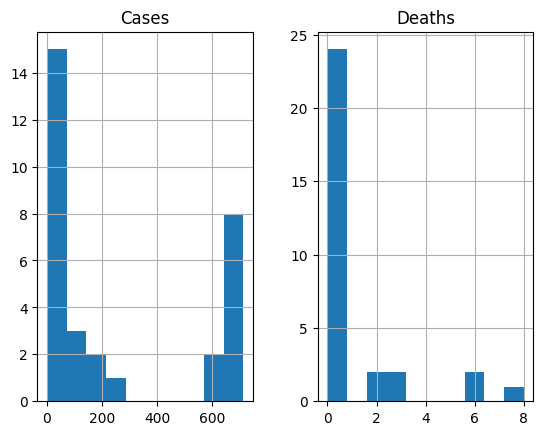

In [47]:
january.hist()

---

## ✅ Notes for Readers
- This notebook demonstrates a **baseline ML approach** to pandemic data.  
- For time‑series forecasting, consider time‑aware splits and specialized models (ARIMA/LSTM).  
- All code logic is unchanged; only **comments and explanations** were added for clarity.